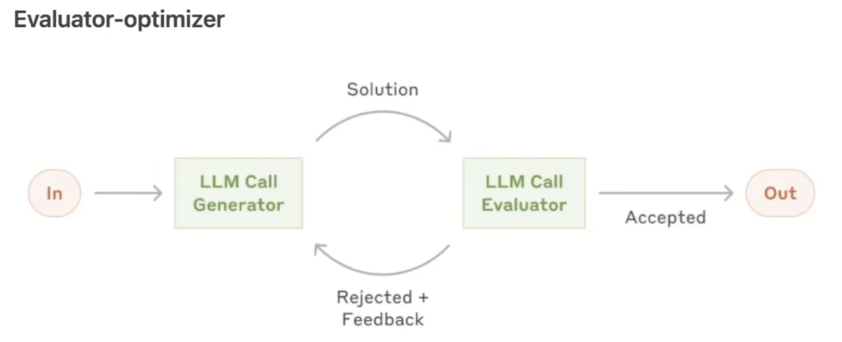

# Evaluator-Optimizer

In [1]:
from typing_extensions import TypedDict
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from IPython.display import Image,display
import os

llm = ChatOpenAI(
    model_name="qwen-turbo-latest",
    base_url=os.getenv("LLM_BASE_URL"),
    api_key=os.getenv("LLM_API_KEY")
)

/Users/daijunjie/miniconda3/envs/langchain-env/lib/python3.12/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [ ]:
from typing import Literal
from pydantic import BaseModel, Field

class FeedBack(BaseModel):
    grade:Literal['funny','not funny'] = Field(
        description='decide if the joke is funny or not'
    )
    feedback: str=Field(
        description='if the joke is not funny,provide feedback on how to improve it.'
    )

# Augment the LLM with schema for structured output
evaluator = llm.with_structured_output(FeedBack)

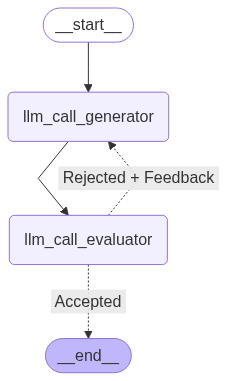

In [5]:
#Graph State
class State(TypedDict):
    joke:str
    topic:str
    feedback:str
    funny_or_not:str

# Nodes
def llm_call_generator(state:State):
    """LLM generates a joke"""
    if state.get('feedback'): # 说明不足够，需要根据反馈调整
        msg = llm.invoke(
            f"""write a joke about {state['topic']} 
            but take into account the feedback:{state['feedback']}"""
        )
    else:
        msg = llm.invoke(
            f"""write a joke about {state['topic']}"""
        )
    return {'joke':msg.content}

def llm_call_evaluator(state:State):
    """LLM evaluates the joke"""
    grade = evaluator.invoke(
        f"grade the joke {state['joke']}. Your response should be a JSON object with the following schema: {{\"grade\": \"funny\" or \"not funny\", \"feedback\": \"if the joke is not funny, provide feedback on how to improve it.\"}}."
    )
    return {'funny_or_not':grade.grade,'feedback':grade.feedback}

# conditional edge function to route back to joke generator or end 
# based upon feedback from the evaluation
def route_joke(state:State):
    """route back to joke generator or end based upon feedback from the evaluation"""
    if state['funny_or_not'] == 'funny':
        return 'Accepted'
    elif state['funny_or_not'] == 'not funny':
        return 'Rejected + Feedback'

# build workflow
optimizer_builder = StateGraph(State)
# add the nodes
optimizer_builder.add_node('llm_call_generator',llm_call_generator)
optimizer_builder.add_node('llm_call_evaluator',llm_call_evaluator)

# add edges to connect nodes
optimizer_builder.add_edge(START,'llm_call_generator')
optimizer_builder.add_edge('llm_call_generator','llm_call_evaluator')

optimizer_builder.add_conditional_edges(
    "llm_call_evaluator",
    route_joke,
    {
        # name returned by route_joke:name of next node to visit
        'Accepted':END,
        'Rejected + Feedback':'llm_call_generator'
    }
)

optimizer_workflow = optimizer_builder.compile()

display(Image(optimizer_workflow.get_graph().draw_mermaid_png()))

In [9]:
from pprint import pprint

for event in optimizer_workflow.stream({'topic':'四战考研调剂双非商科硕士'}):
    pprint(event)

{'llm_call_generator': {'joke': '为什么四战考研、调剂到双非商科硕士的同学，最后都成了“人脉大师”？  \n'
                                '因为——  \n'
                                '第一战：考不上，认识了隔壁班的“学神”。  \n'
                                '第二战：调剂失败，认识了导师的亲戚。  \n'
                                '第三战：双非读研，认识了校友会的“大佬”。  \n'
                                '第四战：毕业季，发现同学都在做金融、咨询、投行……  \n'
                                '他却在朋友圈发：“我这叫——精准定位，低调布局！”  \n'
                                '别人问：“你咋不焦虑？”  \n'
                                '他说：“焦虑啥？我早把‘双非’变成了‘双非凡’！” 😂'}}
{'llm_call_evaluator': {'feedback': '', 'funny_or_not': 'funny'}}


## extra content
和上面内容无关

In [ ]:
class A:
    a:str
    b:int

def func(a:str,b:int,c:A)->str:
    return a* b

import inspect
sig = inspect.signature(func)
print(sig.parameters.values())  # (a: str, b: int) -> str

# 只能获取类型名称，如果是自定义类型，只能获取类名
for k,v in func.__annotations__.items():
    print(k,v.__name__)

odict_values([<Parameter "a: str">, <Parameter "b: int">, <Parameter "c: __main__.A">])
a str
b int
c A
return str
